In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [6]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.001, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred_np, target_np = predictions.detach().cpu().numpy(), firing_rate.detach().cpu().numpy()
            
            correlations = [
                np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                for i in range(9)
            ]
            correlation = np.mean(correlations)
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()
                
                pred_np, target_np = predictions.cpu().numpy(), firing_rate.cpu().numpy()
                correlations = [
                    np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                    for i in range(9)
                ]
                correlation = np.mean(correlations)
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "bncnn_model.pth")
    print("Model saved to bncnn_model.pth")

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_val_predictions = np.vstack(all_val_predictions)
    all_val_targets = np.vstack(all_val_targets)
    
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")

    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    # Plot True vs. Predicted for 9 neurons
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.scatter(all_targets[:, i], all_predictions[:, i], alpha=0.5, label="Train")
        ax.scatter(all_val_targets[:, i], all_val_predictions[:, i], alpha=0.5, label="Validation", color='red')
        ax.plot([all_targets[:, i].min(), all_targets[:, i].max()], [all_targets[:, i].min(), all_targets[:, i].max()], "k--")
        ax.set_xlabel("True Firing Rate")
        ax.set_ylabel("Predicted Firing Rate")
        ax.set_title(f"Neuron {i+1}")
        ax.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/100: 100%|██████████| 10120/10120 [03:25<00:00, 49.34it/s]


Epoch 1/100, Train Loss: -0.113611, Train Acc: 0.1329, Val Loss: -0.304199, Val Acc: 0.1606


Epoch 2/100: 100%|██████████| 10120/10120 [02:53<00:00, 58.37it/s]


Epoch 2/100, Train Loss: -0.454222, Train Acc: 0.1990, Val Loss: -0.568762, Val Acc: 0.2202


Epoch 3/100: 100%|██████████| 10120/10120 [03:02<00:00, 55.46it/s]


Epoch 3/100, Train Loss: -0.897513, Train Acc: 0.2818, Val Loss: -0.894350, Val Acc: 0.2831


Epoch 4/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.50it/s]


Epoch 4/100, Train Loss: -1.313611, Train Acc: 0.3449, Val Loss: -1.137150, Val Acc: 0.3224


Epoch 5/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.11it/s]


Epoch 5/100, Train Loss: -1.589434, Train Acc: 0.3802, Val Loss: -1.297383, Val Acc: 0.3488


Epoch 6/100: 100%|██████████| 10120/10120 [02:30<00:00, 67.39it/s]


Epoch 6/100, Train Loss: -1.779357, Train Acc: 0.4068, Val Loss: -1.386004, Val Acc: 0.3616


Epoch 7/100: 100%|██████████| 10120/10120 [02:24<00:00, 70.09it/s]


Epoch 7/100, Train Loss: -1.907544, Train Acc: 0.4212, Val Loss: -1.502547, Val Acc: 0.3729


Epoch 8/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.46it/s]


Epoch 8/100, Train Loss: -2.012918, Train Acc: 0.4356, Val Loss: -1.524815, Val Acc: 0.3857


Epoch 9/100: 100%|██████████| 10120/10120 [02:57<00:00, 57.15it/s]


Epoch 9/100, Train Loss: -2.088383, Train Acc: 0.4428, Val Loss: -1.600924, Val Acc: 0.3910


Epoch 10/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.02it/s]


Epoch 10/100, Train Loss: -2.148934, Train Acc: 0.4493, Val Loss: -1.642755, Val Acc: 0.3984


Epoch 11/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.33it/s]


Epoch 11/100, Train Loss: -2.199275, Train Acc: 0.4557, Val Loss: -1.777596, Val Acc: 0.4057


Epoch 12/100: 100%|██████████| 10120/10120 [02:24<00:00, 70.22it/s]


Epoch 12/100, Train Loss: -2.244149, Train Acc: 0.4617, Val Loss: -1.724208, Val Acc: 0.4016


Epoch 13/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.91it/s]


Epoch 13/100, Train Loss: -2.283183, Train Acc: 0.4651, Val Loss: -1.853670, Val Acc: 0.4077


Epoch 14/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.27it/s]


Epoch 14/100, Train Loss: -2.315328, Train Acc: 0.4694, Val Loss: -1.878694, Val Acc: 0.4120


Epoch 15/100: 100%|██████████| 10120/10120 [02:33<00:00, 66.03it/s]


Epoch 15/100, Train Loss: -2.358309, Train Acc: 0.4749, Val Loss: -1.907036, Val Acc: 0.4152


Epoch 16/100: 100%|██████████| 10120/10120 [03:09<00:00, 53.50it/s]


Epoch 16/100, Train Loss: -2.385677, Train Acc: 0.4774, Val Loss: -1.882522, Val Acc: 0.4223


Epoch 17/100: 100%|██████████| 10120/10120 [02:56<00:00, 57.18it/s]


Epoch 17/100, Train Loss: -2.409596, Train Acc: 0.4812, Val Loss: -1.911770, Val Acc: 0.4203


Epoch 18/100: 100%|██████████| 10120/10120 [02:28<00:00, 67.99it/s]


Epoch 18/100, Train Loss: -2.430346, Train Acc: 0.4828, Val Loss: -1.945225, Val Acc: 0.4252


Epoch 19/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.29it/s]


Epoch 19/100, Train Loss: -2.453251, Train Acc: 0.4855, Val Loss: -2.013451, Val Acc: 0.4326


Epoch 20/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.22it/s]


Epoch 20/100, Train Loss: -2.480974, Train Acc: 0.4892, Val Loss: -1.910912, Val Acc: 0.4315


Epoch 21/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.02it/s]


Epoch 21/100, Train Loss: -2.494598, Train Acc: 0.4906, Val Loss: -2.062369, Val Acc: 0.4371


Epoch 22/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.27it/s]


Epoch 22/100, Train Loss: -2.520375, Train Acc: 0.4940, Val Loss: -2.053745, Val Acc: 0.4352


Epoch 23/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.66it/s]


Epoch 23/100, Train Loss: -2.539304, Train Acc: 0.4942, Val Loss: -2.029870, Val Acc: 0.4349


Epoch 24/100: 100%|██████████| 10120/10120 [02:45<00:00, 61.18it/s]


Epoch 24/100, Train Loss: -2.547481, Train Acc: 0.4955, Val Loss: -1.988707, Val Acc: 0.4312


Epoch 25/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.68it/s]


Epoch 25/100, Train Loss: -2.573995, Train Acc: 0.4994, Val Loss: -1.987515, Val Acc: 0.4387


Epoch 26/100: 100%|██████████| 10120/10120 [02:32<00:00, 66.26it/s]


Epoch 26/100, Train Loss: -2.584276, Train Acc: 0.5004, Val Loss: -2.085512, Val Acc: 0.4389


Epoch 27/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.36it/s]


Epoch 27/100, Train Loss: -2.604083, Train Acc: 0.5014, Val Loss: -2.131746, Val Acc: 0.4404


Epoch 28/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.45it/s]


Epoch 28/100, Train Loss: -2.615525, Train Acc: 0.5036, Val Loss: -2.043982, Val Acc: 0.4398


Epoch 29/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.71it/s]


Epoch 29/100, Train Loss: -2.631237, Train Acc: 0.5057, Val Loss: -1.992200, Val Acc: 0.4387


Epoch 30/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.13it/s]


Epoch 30/100, Train Loss: -2.639024, Train Acc: 0.5058, Val Loss: -2.001578, Val Acc: 0.4364


Epoch 31/100: 100%|██████████| 10120/10120 [02:38<00:00, 64.01it/s]


Epoch 31/100, Train Loss: -2.649275, Train Acc: 0.5076, Val Loss: -2.144986, Val Acc: 0.4430


Epoch 32/100: 100%|██████████| 10120/10120 [02:34<00:00, 65.43it/s]


Epoch 32/100, Train Loss: -2.669262, Train Acc: 0.5110, Val Loss: -2.084683, Val Acc: 0.4428


Epoch 33/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.62it/s]


Epoch 33/100, Train Loss: -2.677629, Train Acc: 0.5120, Val Loss: -1.987327, Val Acc: 0.4468


Epoch 34/100: 100%|██████████| 10120/10120 [02:33<00:00, 66.02it/s]


Epoch 34/100, Train Loss: -2.689066, Train Acc: 0.5129, Val Loss: -2.128820, Val Acc: 0.4472


Epoch 35/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.55it/s]


Epoch 35/100, Train Loss: -2.694872, Train Acc: 0.5132, Val Loss: -2.122877, Val Acc: 0.4413


Epoch 36/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.23it/s]


Epoch 36/100, Train Loss: -2.704580, Train Acc: 0.5143, Val Loss: -2.103278, Val Acc: 0.4491


Epoch 37/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.85it/s]


Epoch 37/100, Train Loss: -2.708742, Train Acc: 0.5160, Val Loss: -2.149412, Val Acc: 0.4460


Epoch 38/100: 100%|██████████| 10120/10120 [02:28<00:00, 68.36it/s]


Epoch 38/100, Train Loss: -2.721789, Train Acc: 0.5171, Val Loss: -2.186018, Val Acc: 0.4509


Epoch 39/100: 100%|██████████| 10120/10120 [03:43<00:00, 45.31it/s]


Epoch 39/100, Train Loss: -2.732845, Train Acc: 0.5183, Val Loss: -2.151310, Val Acc: 0.4507


Epoch 40/100: 100%|██████████| 10120/10120 [02:59<00:00, 56.48it/s]


Epoch 40/100, Train Loss: -2.739454, Train Acc: 0.5187, Val Loss: -2.184783, Val Acc: 0.4503


Epoch 41/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.21it/s]


Epoch 41/100, Train Loss: -2.744179, Train Acc: 0.5195, Val Loss: -2.053793, Val Acc: 0.4510


Epoch 42/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.15it/s]


Epoch 42/100, Train Loss: -2.755074, Train Acc: 0.5199, Val Loss: -2.290448, Val Acc: 0.4552


Epoch 43/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.18it/s]


Epoch 43/100, Train Loss: -2.764599, Train Acc: 0.5214, Val Loss: -2.272360, Val Acc: 0.4557


Epoch 44/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.77it/s]


Epoch 44/100, Train Loss: -2.763210, Train Acc: 0.5230, Val Loss: -2.295393, Val Acc: 0.4550


Epoch 45/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.27it/s]


Epoch 45/100, Train Loss: -2.775502, Train Acc: 0.5231, Val Loss: -2.288281, Val Acc: 0.4551


Epoch 46/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.46it/s]


Epoch 46/100, Train Loss: -2.779995, Train Acc: 0.5245, Val Loss: -2.235091, Val Acc: 0.4561


Epoch 47/100: 100%|██████████| 10120/10120 [02:43<00:00, 61.74it/s]


Epoch 47/100, Train Loss: -2.783090, Train Acc: 0.5259, Val Loss: -2.318093, Val Acc: 0.4546


Epoch 48/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.57it/s]


Epoch 48/100, Train Loss: -2.792957, Train Acc: 0.5268, Val Loss: -2.401943, Val Acc: 0.4622


Epoch 49/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.16it/s]


Epoch 49/100, Train Loss: -2.794661, Train Acc: 0.5272, Val Loss: -2.128362, Val Acc: 0.4570


Epoch 50/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.39it/s]


Epoch 50/100, Train Loss: -2.801116, Train Acc: 0.5269, Val Loss: -2.359433, Val Acc: 0.4578


Epoch 51/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.30it/s]


Epoch 51/100, Train Loss: -2.805162, Train Acc: 0.5271, Val Loss: -2.350842, Val Acc: 0.4631


Epoch 52/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.45it/s]


Epoch 52/100, Train Loss: -2.811259, Train Acc: 0.5292, Val Loss: -2.382261, Val Acc: 0.4639


Epoch 53/100: 100%|██████████| 10120/10120 [02:29<00:00, 67.63it/s]


Epoch 53/100, Train Loss: -2.817493, Train Acc: 0.5296, Val Loss: -2.380403, Val Acc: 0.4658


Epoch 54/100: 100%|██████████| 10120/10120 [02:42<00:00, 62.38it/s]


Epoch 54/100, Train Loss: -2.820007, Train Acc: 0.5305, Val Loss: -2.296919, Val Acc: 0.4648


Epoch 55/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.14it/s]


Epoch 55/100, Train Loss: -2.827863, Train Acc: 0.5314, Val Loss: -2.349467, Val Acc: 0.4626


Epoch 56/100: 100%|██████████| 10120/10120 [02:18<00:00, 72.91it/s]


Epoch 56/100, Train Loss: -2.834320, Train Acc: 0.5325, Val Loss: -2.312174, Val Acc: 0.4671


Epoch 57/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.94it/s]


Epoch 57/100, Train Loss: -2.843622, Train Acc: 0.5318, Val Loss: -2.381050, Val Acc: 0.4655


Epoch 58/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.12it/s]


Epoch 58/100, Train Loss: -2.846522, Train Acc: 0.5324, Val Loss: -2.393378, Val Acc: 0.4614


Epoch 59/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.62it/s]


Epoch 59/100, Train Loss: -2.848686, Train Acc: 0.5334, Val Loss: -2.397302, Val Acc: 0.4647


Epoch 60/100: 100%|██████████| 10120/10120 [02:34<00:00, 65.65it/s]


Epoch 60/100, Train Loss: -2.852083, Train Acc: 0.5332, Val Loss: -2.422168, Val Acc: 0.4679


Epoch 61/100: 100%|██████████| 10120/10120 [02:55<00:00, 57.63it/s]


Epoch 61/100, Train Loss: -2.852036, Train Acc: 0.5338, Val Loss: -2.406656, Val Acc: 0.4654


Epoch 62/100: 100%|██████████| 10120/10120 [03:10<00:00, 53.17it/s]


Epoch 62/100, Train Loss: -2.859869, Train Acc: 0.5343, Val Loss: -2.412519, Val Acc: 0.4662


Epoch 63/100: 100%|██████████| 10120/10120 [02:53<00:00, 58.32it/s]


Epoch 63/100, Train Loss: -2.862547, Train Acc: 0.5351, Val Loss: -2.457564, Val Acc: 0.4676


Epoch 64/100: 100%|██████████| 10120/10120 [02:40<00:00, 62.95it/s]


Epoch 64/100, Train Loss: -2.864322, Train Acc: 0.5362, Val Loss: -2.416707, Val Acc: 0.4655


Epoch 65/100: 100%|██████████| 10120/10120 [02:36<00:00, 64.53it/s]


Epoch 65/100, Train Loss: -2.869748, Train Acc: 0.5352, Val Loss: -2.422036, Val Acc: 0.4677


Epoch 66/100: 100%|██████████| 10120/10120 [02:34<00:00, 65.47it/s]


Epoch 66/100, Train Loss: -2.871204, Train Acc: 0.5345, Val Loss: -2.431668, Val Acc: 0.4658


Epoch 67/100: 100%|██████████| 10120/10120 [02:34<00:00, 65.49it/s]


Epoch 67/100, Train Loss: -2.880494, Train Acc: 0.5364, Val Loss: -2.377201, Val Acc: 0.4695


Epoch 68/100: 100%|██████████| 10120/10120 [02:44<00:00, 61.70it/s]


Epoch 68/100, Train Loss: -2.879055, Train Acc: 0.5370, Val Loss: -2.478975, Val Acc: 0.4687


Epoch 69/100: 100%|██████████| 10120/10120 [03:06<00:00, 54.39it/s]


Epoch 69/100, Train Loss: -2.877614, Train Acc: 0.5373, Val Loss: -2.467211, Val Acc: 0.4691


Epoch 70/100: 100%|██████████| 10120/10120 [02:46<00:00, 60.88it/s]


Epoch 70/100, Train Loss: -2.889160, Train Acc: 0.5377, Val Loss: -2.440253, Val Acc: 0.4675


Epoch 71/100: 100%|██████████| 10120/10120 [02:24<00:00, 70.23it/s]


Epoch 71/100, Train Loss: -2.890186, Train Acc: 0.5378, Val Loss: -2.425642, Val Acc: 0.4707


Epoch 72/100: 100%|██████████| 10120/10120 [1:16:48<00:00,  2.20it/s]    


Epoch 72/100, Train Loss: -2.889835, Train Acc: 0.5394, Val Loss: -2.458925, Val Acc: 0.4716


Epoch 73/100: 100%|██████████| 10120/10120 [03:23<00:00, 49.62it/s]


Epoch 73/100, Train Loss: -2.895442, Train Acc: 0.5389, Val Loss: -2.498244, Val Acc: 0.4720


Epoch 74/100: 100%|██████████| 10120/10120 [02:56<00:00, 57.31it/s]


Epoch 74/100, Train Loss: -2.900282, Train Acc: 0.5394, Val Loss: -2.458683, Val Acc: 0.4678


Epoch 75/100: 100%|██████████| 10120/10120 [03:07<00:00, 54.00it/s]


Epoch 75/100, Train Loss: -2.907376, Train Acc: 0.5406, Val Loss: -2.433132, Val Acc: 0.4705


Epoch 76/100: 100%|██████████| 10120/10120 [02:49<00:00, 59.82it/s]


Epoch 76/100, Train Loss: -2.908630, Train Acc: 0.5408, Val Loss: -2.442137, Val Acc: 0.4673


Epoch 77/100: 100%|██████████| 10120/10120 [02:38<00:00, 63.92it/s]


Epoch 77/100, Train Loss: -2.910839, Train Acc: 0.5415, Val Loss: -2.501253, Val Acc: 0.4726


Epoch 78/100: 100%|██████████| 10120/10120 [02:27<00:00, 68.76it/s]


Epoch 78/100, Train Loss: -2.910716, Train Acc: 0.5410, Val Loss: -2.475310, Val Acc: 0.4693


Epoch 79/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.11it/s]


Epoch 79/100, Train Loss: -2.911371, Train Acc: 0.5396, Val Loss: -2.472991, Val Acc: 0.4697


Epoch 80/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.39it/s]


Epoch 80/100, Train Loss: -2.916162, Train Acc: 0.5415, Val Loss: -2.475585, Val Acc: 0.4749


Epoch 81/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.67it/s]


Epoch 81/100, Train Loss: -2.922628, Train Acc: 0.5432, Val Loss: -2.476021, Val Acc: 0.4718


Epoch 82/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.44it/s]


Epoch 82/100, Train Loss: -2.918937, Train Acc: 0.5424, Val Loss: -2.317668, Val Acc: 0.4724


Epoch 83/100: 100%|██████████| 10120/10120 [02:30<00:00, 67.15it/s]


Epoch 83/100, Train Loss: -2.924305, Train Acc: 0.5431, Val Loss: -2.508360, Val Acc: 0.4745


Epoch 84/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.70it/s]


Epoch 84/100, Train Loss: -2.929866, Train Acc: 0.5425, Val Loss: -2.485120, Val Acc: 0.4711


Epoch 85/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.86it/s]


Epoch 85/100, Train Loss: -2.926174, Train Acc: 0.5412, Val Loss: -2.502565, Val Acc: 0.4766


Epoch 86/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.49it/s]


Epoch 86/100, Train Loss: -2.931582, Train Acc: 0.5438, Val Loss: -2.529732, Val Acc: 0.4769


Epoch 87/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.18it/s]


Epoch 87/100, Train Loss: -2.941153, Train Acc: 0.5445, Val Loss: -2.502264, Val Acc: 0.4730


Epoch 88/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.58it/s]


Epoch 88/100, Train Loss: -2.935392, Train Acc: 0.5433, Val Loss: -2.506404, Val Acc: 0.4727


Epoch 89/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.80it/s]


Epoch 89/100, Train Loss: -2.935914, Train Acc: 0.5432, Val Loss: -2.515805, Val Acc: 0.4731


Epoch 90/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.49it/s]


Epoch 90/100, Train Loss: -2.943503, Train Acc: 0.5461, Val Loss: -2.486844, Val Acc: 0.4768


Epoch 91/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.53it/s]


Epoch 91/100, Train Loss: -2.944032, Train Acc: 0.5457, Val Loss: -2.496518, Val Acc: 0.4739


Epoch 92/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.37it/s]


Epoch 92/100, Train Loss: -2.948285, Train Acc: 0.5462, Val Loss: -2.460922, Val Acc: 0.4707


Epoch 93/100: 100%|██████████| 10120/10120 [02:29<00:00, 67.88it/s]


Epoch 93/100, Train Loss: -2.949045, Train Acc: 0.5433, Val Loss: -2.545694, Val Acc: 0.4783


Epoch 94/100: 100%|██████████| 10120/10120 [02:40<00:00, 62.92it/s]


Epoch 94/100, Train Loss: -2.950425, Train Acc: 0.5472, Val Loss: -2.496252, Val Acc: 0.4716


Epoch 95/100: 100%|██████████| 10120/10120 [02:51<00:00, 58.89it/s]


Epoch 95/100, Train Loss: -2.946131, Train Acc: 0.5465, Val Loss: -2.548030, Val Acc: 0.4776


Epoch 96/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.93it/s]


Epoch 96/100, Train Loss: -2.951518, Train Acc: 0.5467, Val Loss: -2.507684, Val Acc: 0.4751


Epoch 97/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.39it/s]


Epoch 97/100, Train Loss: -2.961180, Train Acc: 0.5480, Val Loss: -2.529007, Val Acc: 0.4778


Epoch 98/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.30it/s]


Epoch 98/100, Train Loss: -2.958667, Train Acc: 0.5480, Val Loss: -2.544047, Val Acc: 0.4753


Epoch 99/100: 100%|██████████| 10120/10120 [02:37<00:00, 64.09it/s]


Epoch 99/100, Train Loss: -2.958904, Train Acc: 0.5458, Val Loss: -2.522898, Val Acc: 0.4766


Epoch 100/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.33it/s]


Epoch 100/100, Train Loss: -2.958673, Train Acc: 0.5473, Val Loss: -2.527583, Val Acc: 0.4734
Model saved to bncnn_model.pth
Final Training Loss: -2.958673
Final Training Accuracy: 0.5473
Final Validation Loss: -2.527583
Final Validation Accuracy: 0.4734
Shape of final training prediction array: (323821, 9)
Shape of final training actual array: (323821, 9)
Shape of final validation prediction array: (35981, 9)
Shape of final validation actual array: (35981, 9)


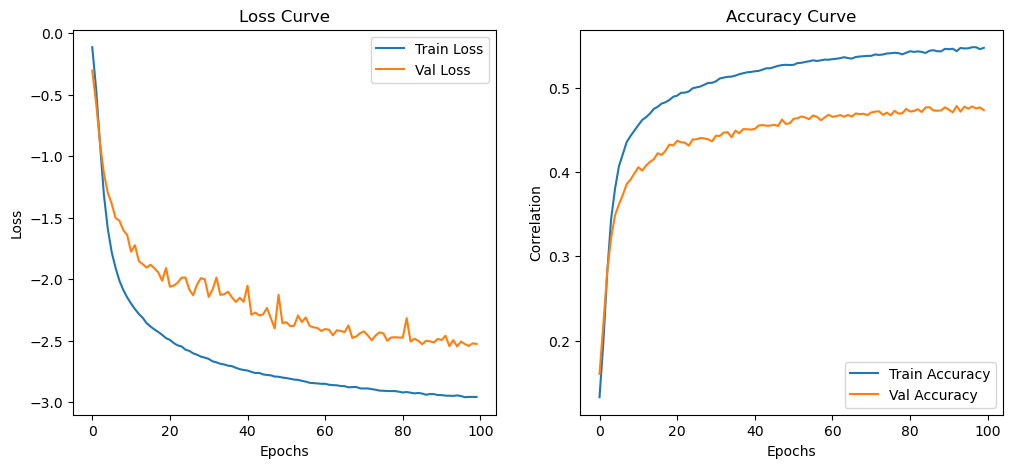

C:\Users\krmri\AppData\Local\Temp\ipykernel_9936\2214774187.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\krmri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


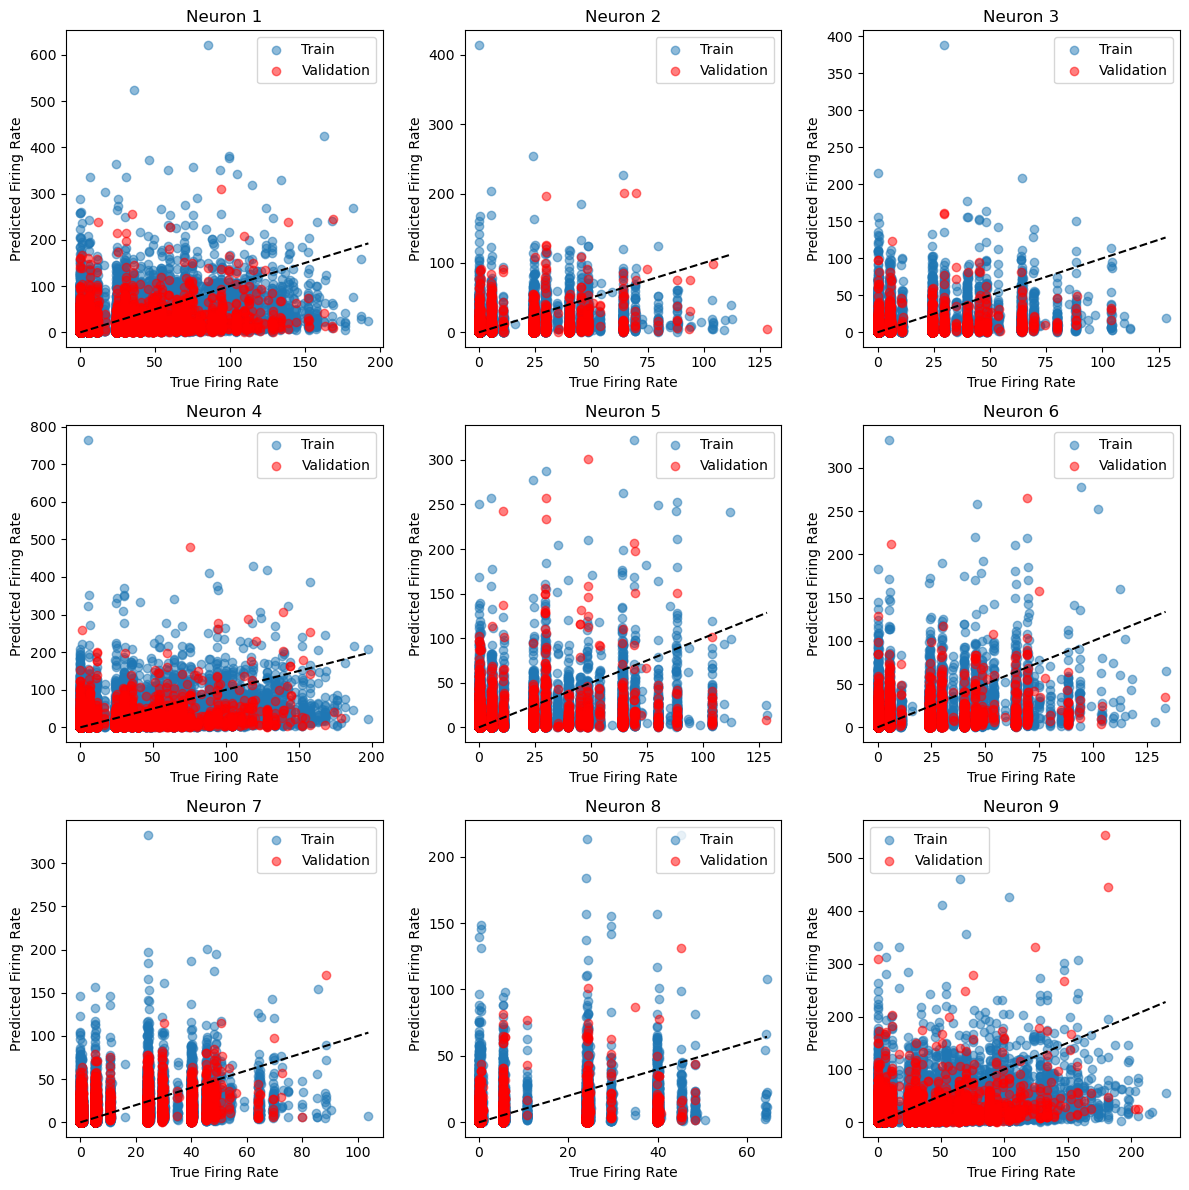

In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
train_model(h5_path, hyperparams)